In [2]:
# Importation des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns
import sklearn

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.multiclass import unique_labels

from pycaret.classification import *
from imblearn.combine import SMOTETomek
from shap import Explanation


import pickle
import shap
import optuna
from optuna.integration.mlflow import MLflowCallback
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


from lightgbm import LGBMClassifier
import mlflow
import mlflow.lightgbm
import gc
import os
mlflow.set_tracking_uri(r'file///C:\Users\Imtech\Desktop\DATA_SCIENTIST\PORJET_7\mlruns')

%matplotlib inline

In [4]:
train_df = pd.read_csv('train_df_cleaned.csv', index_col=0)
to_drop = ['TARGET','SK_ID_CURR']
train_df.sample(10)

,TARGET,SK_ID_CURR,ACTIVE_AMT_ANNUITY_MAX,ACTIVE_AMT_ANNUITY_MEAN,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_SUM_DEBT_MAX,ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,ACTIVE_AMT_CREDIT_SUM_DEBT_SUM,ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN,ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM,...,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
137428,0.0,259387,-0.025301,-0.032646,-0.123177,0.176927,0.190486,0.183961,-0.188356,-0.205962,...,0,0,0,0,0.045915,0.045247,0.049484,0.014939,0.015280,0.028158
213028,1.0,346864,-0.025301,-0.032646,-0.123177,-0.226045,-0.199214,-0.234826,-0.188356,-0.205962,...,0,0,1,0,0.045915,0.045247,0.049484,0.014939,0.015280,0.028158
138715,0.0,260848,-0.025301,-0.032646,-0.123177,-0.194373,-0.141894,-0.033584,-0.188356,-0.205962,...,0,0,0,0,0.476159,0.470851,0.443999,0.014939,0.015280,0.028158
128422,0.0,248964,-0.032945,0.007858,-0.123177,-0.388703,-0.357571,-0.390158,-0.188356,-0.205962,...,0,0,0,1,0.045915,0.045247,0.049484,0.014939,0.015280,0.028158
259260,1.0,400041,0.006458,-0.117334,0.013072,-0.421767,-0.391314,-0.425506,-0.188356,-0.205962,...,0,0,0,1,0.045915,0.045247,0.049484,0.014939,0.015280,0.028158
108955,0.0,226372,-0.061876,-0.130469,0.830652,0.960873,0.218723,0.852588,-0.188356,-0.205962,...,0,0,0,1,0.045915,0.045247,0.049484,0.014939,0.015280,0.028158
303210,0.0,451295,-0.025301,-0.032646,-0.123177,-0.226045,-0.199214,-0.234826,-0.188356,-0.205962,...,0,0,0,1,0.106005,0.104689,0.104584,0.428706,0.427361,0.436338
79732,0.0,192422,-0.025301,-0.032646,-0.123177,-0.226045,-0.199214,-0.234826,-0.188356,-0.205962,...,0,0,0,0,-0.143969,-0.142589,-0.124632,-1.743569,-1.739138,-1.709346
83140,0.0,196429,-0.025301,-0.032646,-0.123177,-0.226045,-0.199214,-0.234826,-0.188356,-0.205962,...,0,0,0,0,0.069951,0.069024,0.071524,0.118381,0.118301,0.129812
110976,0.0,228742,-0.025301,-0.032646,-0.123177,-0.253911,-0.233340,0.070954,-0.188356,-0.205962,...,0,0,0,1,0.057933,0.057136,0.060504,0.014939,0.015280,0.028158


<AxesSubplot:>

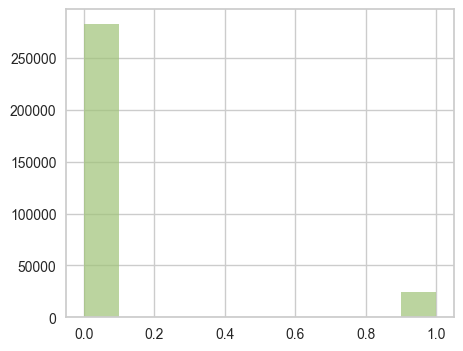

In [11]:
train_df.TARGET.hist(figsize = (5, 4), color='g', alpha = 0.7)

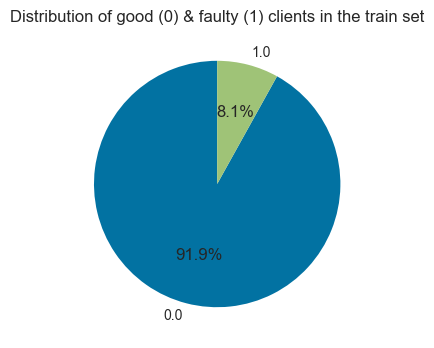

In [12]:
value_counts = train_df.TARGET.value_counts()

plt.figure(figsize=(4, 4))
value_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Distribution of good (0) & faulty (1) clients in the train set')
plt.ylabel('')
plt.show()

# Find a baseline model
* The idea is to select top3 models that are adapted to the analysis before: i.e having the best AUC and F1 scores and a short processing time

### Step 0: Identify top 3 models based on a sample of 6000 

In [5]:
sample_size = 60000

sample_df = train_df.sample(n=sample_size)
X_train = sample_df.drop(to_drop, axis=1)
y_train = sample_df['TARGET']

In [6]:
clf_setup = setup(data=pd.concat([X_train, y_train], axis=1), target='TARGET', n_jobs = 1, fix_imbalance = False, log_experiment=False)

# Compare and select top models
mlflow.set_experiment("Step1_Search_Baseline_Sample_6000")
with mlflow.start_run(""):
    raw_models = compare_models()
    raw_results = pull()
    raw_results = raw_results.sort_values(by='AUC', ascending=False)
    raw_results.to_csv("raw_results.csv", index=False)
    # Log the CSV file as an artifact
    mlflow.log_artifact("raw_results.csv")
mlflow.end_run()
raw_results

,Description,Value
0,Session id,7739
1,Target,TARGET
2,Target type,Binary
3,Original data shape,"(60000, 740)"
4,Transformed data shape,"(60000, 740)"
5,Transformed train set shape,"(42000, 740)"
6,Transformed test set shape,"(18000, 740)"
7,Numeric features,739
8,Preprocess,True
9,Imputation type,simple


2024/02/10 20:21:06 INFO mlflow.tracking.fluent: Experiment with name 'Step1_Search_Baseline_Sample_6000' does not exist. Creating a new experiment.


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9188,0.6963,0.0009,0.2500,0.0018,0.0015,0.0133,79.3540
et,Extra Trees Classifier,0.9188,0.7001,0.0006,0.2000,0.0012,0.0010,0.0099,32.9600
dummy,Dummy Classifier,0.9188,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0330
gbc,Gradient Boosting Classifier,0.9187,0.7643,0.0273,0.4965,0.0514,0.0433,0.1003,284.1860
ridge,Ridge Classifier,0.9185,0.0000,0.0018,0.2483,0.0035,0.0024,0.0143,1.6580
ada,Ada Boost Classifier,0.9177,0.7478,0.0454,0.4255,0.0817,0.0676,0.1175,55.0480
lr,Logistic Regression,0.9174,0.7539,0.0457,0.4189,0.0820,0.0674,0.1163,34.2060
lightgbm,Light Gradient Boosting Machine,0.9174,0.7603,0.0366,0.4135,0.0671,0.0545,0.1029,13.8610
knn,K Neighbors Classifier,0.9140,0.5580,0.0170,0.1790,0.0310,0.0175,0.0318,6.8620
lda,Linear Discriminant Analysis,0.9138,0.7553,0.0721,0.3525,0.1194,0.0945,0.1288,8.4190


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9187,0.7643,0.0273,0.4965,0.0514,0.0433,0.1003,284.186
lightgbm,Light Gradient Boosting Machine,0.9174,0.7603,0.0366,0.4135,0.0671,0.0545,0.1029,13.861
lda,Linear Discriminant Analysis,0.9138,0.7553,0.0721,0.3525,0.1194,0.0945,0.1288,8.419
lr,Logistic Regression,0.9174,0.7539,0.0457,0.4189,0.0820,0.0674,0.1163,34.206
ada,Ada Boost Classifier,0.9177,0.7478,0.0454,0.4255,0.0817,0.0676,0.1175,55.048
et,Extra Trees Classifier,0.9188,0.7001,0.0006,0.2000,0.0012,0.0010,0.0099,32.960
rf,Random Forest Classifier,0.9188,0.6963,0.0009,0.2500,0.0018,0.0015,0.0133,79.354
knn,K Neighbors Classifier,0.9140,0.5580,0.0170,0.1790,0.0310,0.0175,0.0318,6.862
dt,Decision Tree Classifier,0.8507,0.5385,0.1656,0.1417,0.1526,0.0714,0.0717,37.226
nb,Naive Bayes,0.1343,0.5118,0.9616,0.0830,0.1529,0.0039,0.0264,1.665


In [34]:
#!mlflow ui

^C


TRADE-OFF AUC SCORE VS Time:
* Light Gradient Boosting Machine -->	AUC: 0.7645 vs TT: 0.7645 (Sec)
* Linear Discriminant Analysis --> AUC: 0.7516 vs TT: 14.641 (Sec)
* Ada Boost Classifier --> AUC: 0.7514 vs TT: 87.503 (Sec)

* Will now assess the top 3 models on the entire data set.

### Step 1: Identify the baseline

In [7]:
gc.collect()
X_train = train_df.drop('TARGET', axis=1)
y_train = train_df['TARGET']


In [8]:

clf_setup = setup(data=pd.concat([X_train, y_train], axis=1), target='TARGET', n_jobs = 1, fix_imbalance = False, log_experiment=False)

# Compare and select top models
mlflow.set_experiment("Step2_Search_Baseline_")
with mlflow.start_run(""):
    baseline_model = compare_models(['lightgbm', 'lda', 'ada', 'dummy'])
    baseline_result = pull()
    baseline_result = baseline_result.sort_values(by='AUC', ascending=False)
    baseline_result.to_csv("results_baseline.csv", index=False)
    # Log the CSV file as an artifact
    mlflow.log_artifact("results_baseline.csv")

mlflow.end_run()
baseline_result

,Description,Value
0,Session id,5554
1,Target,TARGET
2,Target type,Binary
3,Original data shape,"(307507, 741)"
4,Transformed data shape,"(307507, 741)"
5,Transformed train set shape,"(215254, 741)"
6,Transformed test set shape,"(92253, 741)"
7,Numeric features,740
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9197,0.7793,0.0384,0.5414,0.0717,0.0616,0.1282,66.5170
dummy,Dummy Classifier,0.9193,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,7.2570
ada,Ada Boost Classifier,0.9189,0.7613,0.0323,0.4666,0.0604,0.0505,0.1060,323.6910
lda,Linear Discriminant Analysis,0.9175,0.7699,0.0624,0.4236,0.1087,0.0898,0.1380,47.3330


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9197,0.7793,0.0384,0.5414,0.0717,0.0616,0.1282,66.517
lda,Linear Discriminant Analysis,0.9175,0.7699,0.0624,0.4236,0.1087,0.0898,0.1380,47.333
ada,Ada Boost Classifier,0.9189,0.7613,0.0323,0.4666,0.0604,0.0505,0.1060,323.691
dummy,Dummy Classifier,0.9193,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,7.257


The Winner is:
* Light Gradient Boosting Machine -->	AUC: 0.7803 vs TT: 99.3 (Sec)


In [34]:
mlflow.set_experiment("Step2_Search_Baseline_")
with mlflow.start_run("8a2d7336b302432e915e5366ab6c7272"):
    #Confusion matrix plot
    confusion_matrix_plot = plot_model(baseline_model, plot = 'confusion_matrix',  save=True)
    mlflow.log_artifact(confusion_matrix_plot)
    #ROC-AUC plot
    auc_roc_plot = plot_model(baseline_model, plot='auc',  save=True)
    mlflow.log_artifact(auc_roc_plot)
mlflow.end_run()

Traceback (most recent call last):
  File "c:\Users\Imtech\AppData\Local\Programs\Python\Python39\lib\site-packages\mlflow\store\tracking\file_store.py", line 271, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "c:\Users\Imtech\AppData\Local\Programs\Python\Python39\lib\site-packages\mlflow\store\tracking\file_store.py", line 405, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "c:\Users\Imtech\AppData\Local\Programs\Python\Python39\lib\site-packages\mlflow\store\tracking\file_store.py", line 1109, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "c:\Users\Imtech\AppData\Local\Programs\Python\Python39\lib\site-packages\mlflow\store\tracking\file_store.py", line 1102, in _read_helper
    result = read_yaml(root, file_name)
  File "c:\Users\Imtech\AppData\Local\Programs\Python\Python39\lib\site-packages\mlflow\utils\file_utils.py", line 183, in read_yaml


# Step2: Define a sampling strategy

In [35]:
train_df = pd.read_csv('train_df_cleaned.csv', index_col=0)
to_drop = ['TARGET','SK_ID_CURR']
X_train, X_val, y_train, y_val = train_test_split(train_df.drop(to_drop, axis=1), train_df['TARGET'], test_size=0.2)

del train_df
gc.collect()

234

In [40]:
# Business-specific cost-sensitive scoring function
def business_cost_scorer(y_true, y_pred_prob, threshold, cost_weight=10):
    y_pred = (y_pred_prob >= threshold).astype(int)
    print(type(y_true), type(y_pred))
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = (cost_weight * fn + fp) / len(y_true)  # Cost function based on business requirements
    
    return cost  # Positive to indicate that higher cost is worse

def evaluate_pipeline(name, pipeline, param_grid, X_train, y_train, X_val, y_val):
    # Set up parameter grid search using GridSearchCV
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        scoring={'AUC': 'roc_auc', 'Business_Cost': make_scorer(business_cost_scorer, greater_is_better=False, needs_proba=True)},
        cv=5,
        refit='AUC',
        n_jobs=6
    )

    # Fit the model on the data
    grid_search.fit(X_train, y_train)

    # Predict on the validation set using the best models
    y_val_pred_prob_tuned_weight = grid_search.best_estimator_.predict_proba(X_val)[:, 1]
    print('y_val', type(y_val), 'y_val_pred_prob_tuned_weight', type(y_val_pred_prob_tuned_weight))

    # Choose the threshold that minimizes the business cost for both cases
    thresholds_tuned_weight = np.linspace(0, 1, 100)
    business_costs_tuned_weight = [business_cost_scorer(y_val, y_val_pred_prob_tuned_weight, threshold, cost_weight=10) for threshold in thresholds_tuned_weight]

    best_threshold_tuned_weight = thresholds_tuned_weight[np.argmin(business_costs_tuned_weight)]
    print("Best threshold for minimizing business cost (tuned weight):", best_threshold_tuned_weight)

    # Get various scores
    y_val_pred = grid_search.best_estimator_.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    
    # Calculate AUC separately
    fpr, tpr, _ = roc_curve(y_val, y_val_pred_prob_tuned_weight)
    auc_score = auc(fpr, tpr)

    mlflow.log_metric(name + '_Accuracy', accuracy)
    mlflow.log_metric(name + '_Precision', precision)
    mlflow.log_metric(name + '_Recall', recall)
    mlflow.log_metric(name + '_F1 Score', f1)
    mlflow.log_metric(name + '_AUC Score', auc_score)
    mlflow.log_metric(name + '_Lowest business Cost', business_costs_tuned_weight[np.argmin(business_costs_tuned_weight)])
    mlflow.log_metric(name + '_best_threshold_tuned_weight', best_threshold_tuned_weight)

    # Create a DataFrame with scores
    scores_df = pd.DataFrame({'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1_Score': f1,
        'AUC': auc_score, 'Business_Cost': business_costs_tuned_weight[np.argmin(business_costs_tuned_weight)]}, index=[0])

    gc.collect()

    return scores_df, grid_search, best_threshold_tuned_weight, business_costs_tuned_weight

def plot_evaluation(best_model, X_val, y_val, best_threshold_tuned_weight, business_costs_tuned_weight, plot_file_path):
    # Predict on the validation set using the best models
    y_val_pred_prob_tuned_weight = best_model.predict_proba(X_val)[:, 1]

    # Plot confusion matrix, ROC curve, and custom cost function side by side
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Plot confusion matrix using Seaborn's heatmap
    sns.heatmap(confusion_matrix(y_val, best_model.predict(X_val)), annot=True, fmt='d', cmap=plt.cm.Blues, ax=axes[0])
    axes[0].set_title('Confusion Matrix')

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_prob_tuned_weight)
    roc_auc = auc(fpr, tpr)

    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
    axes[1].legend(loc='lower right')

    # Plot custom cost function
    thresholds_tuned_weight = np.linspace(0, 1, 100)

    # Plot the custom cost function
    axes[2].plot(thresholds_tuned_weight, business_costs_tuned_weight, label='Business Cost', color='green')
    axes[2].axvline(x=best_threshold_tuned_weight, color='r', linestyle='--')

    # Add legend with best business cost
    best_cost = round(business_costs_tuned_weight[np.argmin(business_costs_tuned_weight)], 2)
    axes[2].legend([f'Business Cost', f'Best Threshold: {round(best_threshold_tuned_weight, 2)} --> Optimal Business Cost: {best_cost}'], loc='upper right')

    # Set labels and title
    axes[2].set_xlabel('Threshold')
    axes[2].set_ylabel('Business Cost')
    axes[2].set_title('Custom Cost Function')

    gc.collect()

    plt.show()

    fig.savefig(plot_file_path)
    mlflow.log_artifact(plot_file_path)

Traceback (most recent call last):
  File "c:\Users\Imtech\AppData\Local\Programs\Python\Python39\lib\site-packages\mlflow\store\tracking\file_store.py", line 271, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "c:\Users\Imtech\AppData\Local\Programs\Python\Python39\lib\site-packages\mlflow\store\tracking\file_store.py", line 405, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "c:\Users\Imtech\AppData\Local\Programs\Python\Python39\lib\site-packages\mlflow\store\tracking\file_store.py", line 1109, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "c:\Users\Imtech\AppData\Local\Programs\Python\Python39\lib\site-packages\mlflow\store\tracking\file_store.py", line 1102, in _read_helper
    result = read_yaml(root, file_name)
  File "c:\Users\Imtech\AppData\Local\Programs\Python\Python39\lib\site-packages\mlflow\utils\file_utils.py", line 183, in read_yaml


[LightGBM] [Info] Number of positive: 226142, number of negative: 226142
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.962797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141970
[LightGBM] [Info] Number of data points in the train set: 452284, number of used features: 718
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
y_val <class 'pandas.core.series.Series'> y_val_pred_prob_tuned_weight <class 'numpy.ndarray'>
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
<class 'pandas.core.series.Series'> <cla

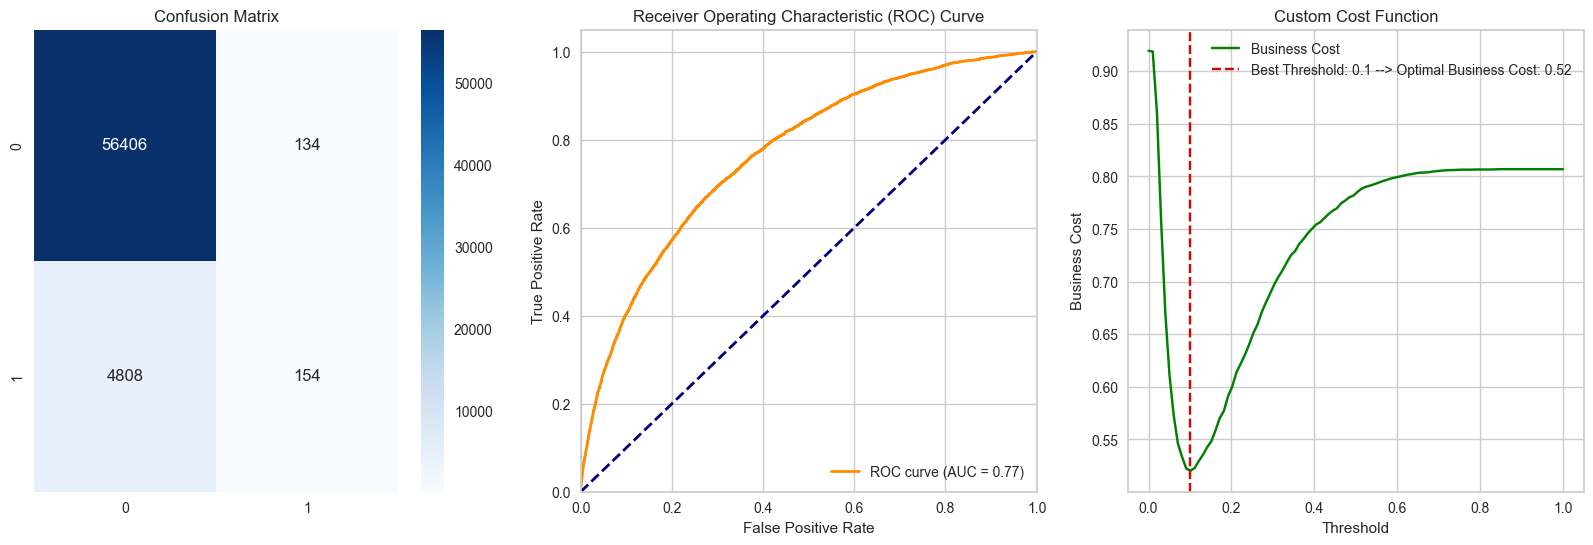


Scores for SMOTE:
   Accuracy  Precision    Recall  F1_Score       AUC  Business_Cost
0  0.919645   0.534722  0.031036  0.058667  0.766572       0.520308
Best Parameters:  {'clf__n_estimators': 100}
Best Model:  Pipeline(memory=None,
         steps=[('over',
                 SMOTE(k_neighbors=5, n_jobs=None, random_state=None,
                       sampling_strategy='auto')),
                ('clf',
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100,
                                n_jobs=None, num_leaves=31, objective=None,
                                random_state=None, reg_alpha=0.0,
                                reg_lambda=0.0, subsample=1.0,
                         

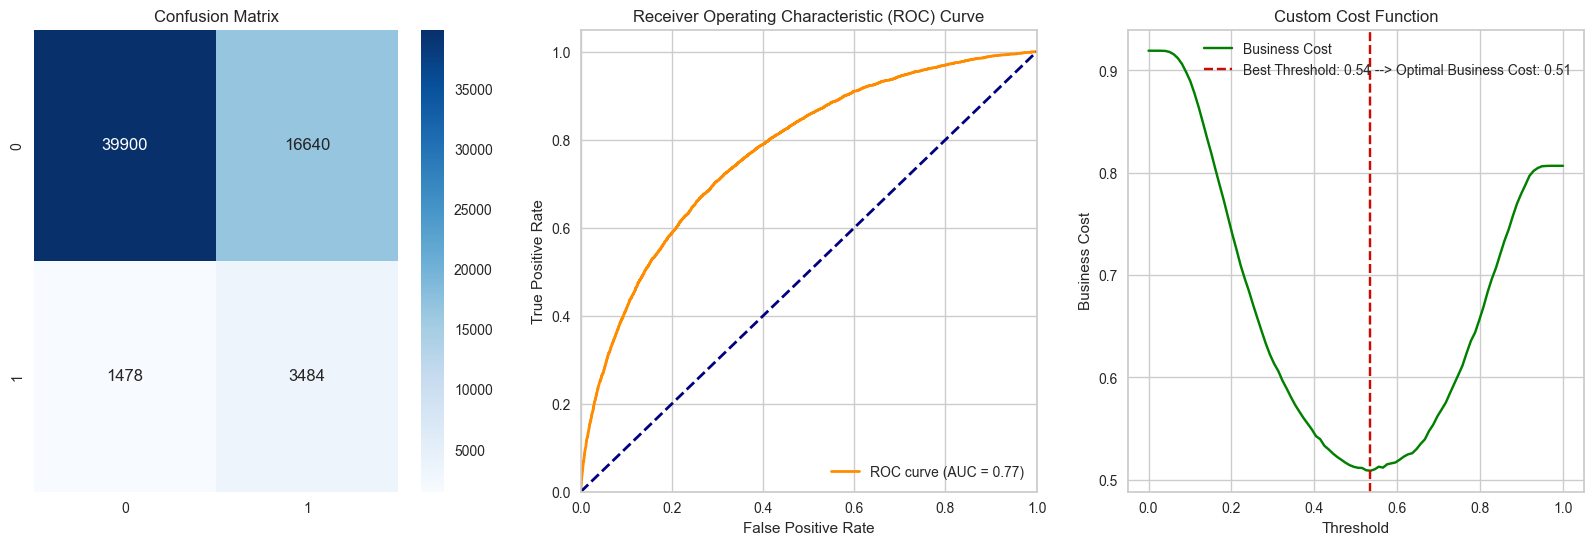


Scores for RandomUnderSampler:
   Accuracy  Precision    Recall  F1_Score       AUC  Business_Cost
0  0.705408   0.173127  0.702136  0.277764  0.774056       0.508683
Best Parameters:  {'clf__n_estimators': 100}
Best Model:  Pipeline(memory=None,
         steps=[('under',
                 RandomUnderSampler(random_state=None, replacement=False,
                                    sampling_strategy='auto')),
                ('clf',
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100,
                                n_jobs=None, num_leaves=31, objective=None,
                                random_state=None, reg_alpha=0.0,
                                reg_lambda=0.0, subsample

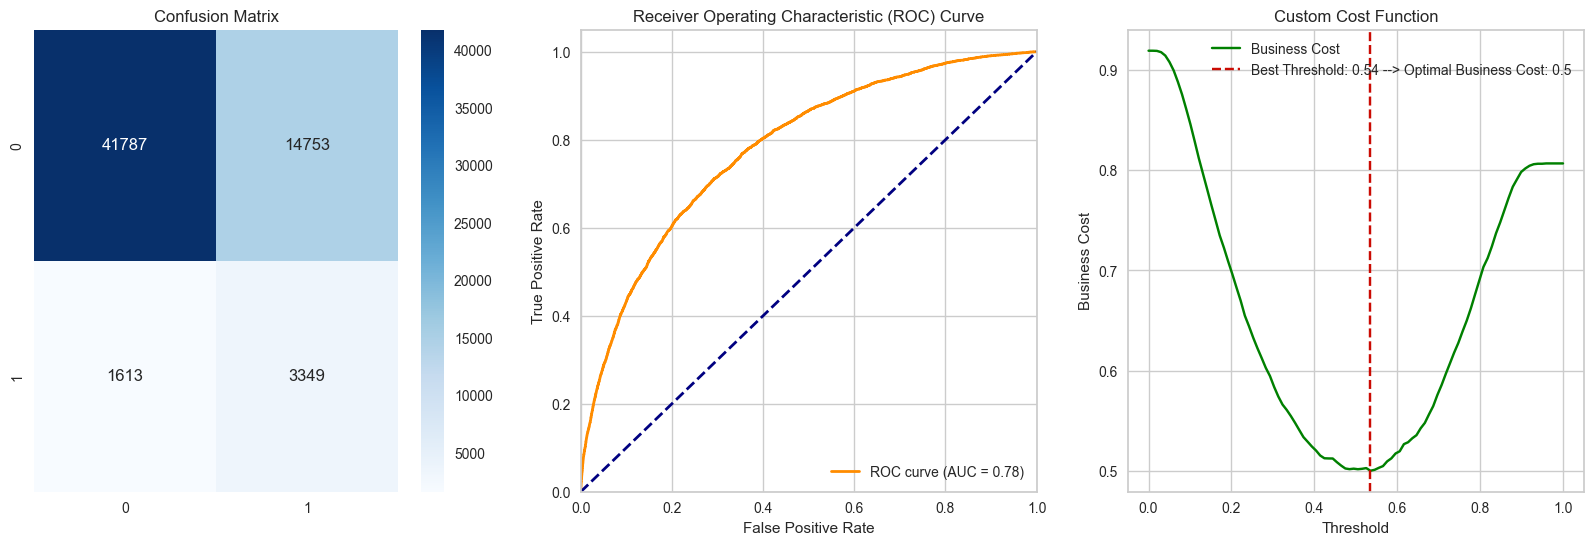


Scores for ImbalanceRatioAdjustment:
   Accuracy  Precision    Recall  F1_Score       AUC  Business_Cost
0  0.733895   0.185007  0.674929  0.290409  0.780745            0.5
Best Parameters:  {'clf__scale_pos_weight': 10.885087851784725}
Best Model:  Pipeline(memory=None,
         steps=[('clf',
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100,
                                n_jobs=None, num_leaves=31, objective=None,
                                random_state=None, reg_alpha=0.0,
                                reg_lambda=0.0,
                                scale_pos_weight=10.885087851784725,
                                subsample=1.0, subsample_for_bin=200000,
      

In [61]:
gc.collect()

all_scores_df = pd.DataFrame()

# Make a pipeline with SMOTE, RandomUnderSampler, and LGBMClassifier
pipeline_smote = Pipeline([
    ('over', SMOTE()),
    ('clf', LGBMClassifier())
])
# Create a pipeline with RandomUnderSampler
pipeline_under = Pipeline([
    ('under', RandomUnderSampler()),
    ('clf', LGBMClassifier())
])
# Create a pipeline with for weightt imbalance
    # Calculate imbalance ratio
imbalance_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
pipeline_imbalance = Pipeline([('clf', LGBMClassifier(scale_pos_weight = imbalance_ratio))])

# Set up parameter grid search using GridSearchCV
param_grid_over_under = {'clf__n_estimators': [100, 10]}
param_grid_imbalance = {'clf__scale_pos_weight': np.linspace(imbalance_ratio - 0.5, imbalance_ratio + 0.5, 2)}

 # Evaluate and compare the three pipelines
All_options = zip(['SMOTE', 'RandomUnderSampler', 'ImbalanceRatioAdjustment'],
                  [(pipeline_smote, param_grid_over_under), (pipeline_under, param_grid_over_under), (pipeline_imbalance, param_grid_imbalance)])

mlflow.set_experiment("Step3_Sampling_and_weight_imbalance")
with mlflow.start_run():
    for name, (pipeline, param_grid) in All_options:
        scores_df, best_model, best_threshold, business_costs  = evaluate_pipeline(name, pipeline, param_grid, X_train, y_train, X_val, y_val)
        model_test = mlflow.sklearn.log_model(best_model.best_estimator_, "best_model_" + name)

        plot_file_path = name + '_plot.png'
        plot_evaluation(best_model, X_val, y_val, best_threshold, business_costs, plot_file_path)

        # Display the scores DataFrame
        print(f"\nScores for {name}:")
        print(scores_df)
        print("Best Parameters: ", best_model.best_params_)
        print("Best Model: ", best_model.best_estimator_)

        # Append scores to the overall DataFrame
        scores_df['Method'] = name
        all_scores_df = all_scores_df.append(scores_df, ignore_index=True)

        ## Store the best model using pickle
        #with open(f'best_model_{name}.obj', 'wb') as model_file:
        #    pickle.dump(best_model.best_estimator_, model_file)
#
        del scores_df, best_model, best_threshold, business_costs
        gc.collect()

    all_scores_df.to_csv("all_scores_df.csv", index=False)
    #mlflow.log_artifact("all_scores_df.csv"

mlflow.end_run()

In [62]:
all_scores_df

,Accuracy,Precision,Recall,F1_Score,AUC,Business_Cost,Method
0,0.919645,0.534722,0.031036,0.058667,0.766572,0.520308,SMOTE
1,0.705408,0.173127,0.702136,0.277764,0.774056,0.508683,RandomUnderSampler
2,0.733895,0.185007,0.674929,0.290409,0.780745,0.500000,ImbalanceRatioAdjustment


In [65]:
mlflow.set_experiment("Step3_Sampling_and_weight_imbalance")
with mlflow.start_run('3d2a6d136b434961bac7be58d73976f6'):
    all_scores_df.to_csv("all_scores_df.csv", index=False)
    mlflow.log_artifact("all_scores_df.csv")
mlflow.end_run()

Traceback (most recent call last):
  File "c:\Users\Imtech\AppData\Local\Programs\Python\Python39\lib\site-packages\mlflow\store\tracking\file_store.py", line 271, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "c:\Users\Imtech\AppData\Local\Programs\Python\Python39\lib\site-packages\mlflow\store\tracking\file_store.py", line 405, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "c:\Users\Imtech\AppData\Local\Programs\Python\Python39\lib\site-packages\mlflow\store\tracking\file_store.py", line 1109, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "c:\Users\Imtech\AppData\Local\Programs\Python\Python39\lib\site-packages\mlflow\store\tracking\file_store.py", line 1102, in _read_helper
    result = read_yaml(root, file_name)
  File "c:\Users\Imtech\AppData\Local\Programs\Python\Python39\lib\site-packages\mlflow\utils\file_utils.py", line 183, in read_yaml


In [70]:
#!mlflow ui

^C


# Step3: Final model optimization

In [66]:
gc.collect()

476

In [6]:
train_df = pd.read_csv('train_df_cleaned.csv', index_col=0)
to_drop = ['TARGET','SK_ID_CURR']
X_train, X_val, y_train, y_val = train_test_split(train_df.drop(to_drop, axis=1), train_df['TARGET'], test_size=0.2)

del train_df
gc.collect()

0

In [38]:

#'num_leaves': trial.suggest_int('num_leaves', 30, 50),
#'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#'subsample':  trial.suggest_uniform('subsample', 0.1, 1.0),
# 'scale_pos_weight': trial.suggest_float('scale_pos_weight', imbalance_ratio - 1, imbalance_ratio + 1),

# -- Setting up mlflow callback
mlflc = MLflowCallback(create_experiment=True,
                       metric_name="Profit", mlflow_kwargs={"nested": True})

# -- Define the objective function
@mlflc.track_in_mlflow()
def objective(trial):
    # Define imbalance ratio
    imbalance_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

    # Params grid
    lgbm_params = {'scale_pos_weight': trial.suggest_loguniform('scale_pos_weight', imbalance_ratio - 2, imbalance_ratio + 2),
                    'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.01),
                    'n_estimators': trial.suggest_int('n_estimators', 100, 4000),
                    'min_child_samples':  trial.suggest_int('min_child_samples', 2, 256),
                    'reg_alpha':  trial.suggest_loguniform('reg_alpha', 1e-8, 1e-3),
                    'reg_lambda':  trial.suggest_loguniform('reg_lambda', 1e-8, 1e-3)
                    }

    # Set up LightGBM classifier with hyperparameters to tune
    lgbm_classifier = LGBMClassifier(**lgbm_params)

    # Create a pipeline
    pipeline = Pipeline([('clf', lgbm_classifier)])

    # Fit the model on the data
    pipeline.fit(X_train, y_train)

    # Predict on the validation set
    y_val_pred_prob = pipeline.predict_proba(X_val)[:, 1]

    # Choose the threshold that minimizes the business cost
    thresholds = np.linspace(0, 1, 100)
    business_costs = [business_cost_scorer(y_val, y_val_pred_prob, threshold) for threshold in thresholds]
    best_threshold = thresholds[np.argmin(business_costs)]
    # Calculate business cost
    business_cost = business_cost_scorer(y_val, y_val_pred_prob, best_threshold)

    return -business_cost  # Optimize for minimizing business cost

def evaluate_and_plot_best_model(best_model, X_val, y_val, plot_file_path='Best_plot_otpuna.png'):
    # Predict on the validation set using the best model
    y_val_pred_prob = best_model.predict_proba(X_val)[:, 1]
    y_val_pred = best_model.predict(X_val)

    # Choose the threshold that minimizes the business cost
    thresholds = np.linspace(0, 1, 100)
    business_costs = [business_cost_scorer(y_val, y_val_pred_prob, threshold) for threshold in thresholds]
    best_threshold = thresholds[np.argmin(business_costs)]

    # Calculate metrics
    fpr, tpr, _ = roc_curve(y_val, y_val_pred_prob)
    auc_score = auc(fpr, tpr)

    accuracy = accuracy_score(y_val, (y_val_pred_prob >= best_threshold).astype(int))
    precision = precision_score(y_val, (y_val_pred_prob >= best_threshold).astype(int))
    recall = recall_score(y_val, (y_val_pred_prob >= best_threshold).astype(int))
    f1 = f1_score(y_val, (y_val_pred_prob >= best_threshold).astype(int))
    business_cost = business_cost_scorer(y_val, y_val_pred_prob, best_threshold)

    # Plot confusion matrix, ROC curve, and custom cost function side by side
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Plot confusion matrix using Seaborn's heatmap
    sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt='d', cmap=plt.cm.Blues, ax=axes[0])
    axes[0].set_title('Confusion Matrix')

    # Plot ROC curve
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
    axes[1].legend(loc='lower right')

    # Plot custom cost function
    axes[2].plot(thresholds, business_costs, label='Business Cost', color='green')
    axes[2].axvline(x=best_threshold, color='r', linestyle='--')

    # Add legend with best business cost
    best_cost = round(business_costs[np.argmin(business_costs)], 4)
    axes[2].legend([f'Business Cost', f'Best Threshold: {round(best_threshold, 4)} --> Optimal Business Cost: {best_cost}'], loc='upper right')

    # Set labels and title
    axes[2].set_xlabel('Threshold')
    axes[2].set_ylabel('Business Cost')
    axes[2].set_title('Custom Cost Function')

    plt.show()

    fig.savefig(plot_file_path)
    plt.close()

    return business_cost, auc_score, accuracy, precision, recall, f1

# Set up mlflow experiment
gc.collect()

494

In [ ]:
gc.collect()
mlflow.set_experiment("Step4_LGBM_optimization")
with mlflow.start_run():
    # Set up Optuna study
    study = optuna.create_study(study_name="Step4_LGBM_optimization", direction='maximize')
    # Use a lambda function to pass the imbalance_ratio as a constant argument to the objective function
    objective_with_imbalance = lambda trial: objective(trial)
    study.optimize(objective_with_imbalance, n_trials=90, callbacks=[mlflc])  # You can adjust the number of trials

    # Get the best hyperparameters
    best_params_BC = study.best_params
    # Set up LightGBM classifier with the best hyperparameters
    best_lgbm_classifier = LGBMClassifier(**best_params_BC)

    # Save the best model using pickle
    best_lgbm_classifier.fit(X_train, y_train)

    mlflow.sklearn.log_model(best_lgbm_classifier, "best_model_Step4_optimization")

    #with open('best_model_Step3_optimization.pkl', 'wb') as model_file:
    #    pickle.dump((best_lgbm_classifier, best_lgbm_classifier.booster_), model_file)

    plot_file_path = 'Step4_LGBM_optimization.png'

    # Evaluate and plot the best model
    business_metric, auc_score, accuracy, precision, recall, f1 = evaluate_and_plot_best_model(best_lgbm_classifier, X_val, y_val, plot_file_path)

    # Log hyperparameters and metrics to mlflow
    mlflow.log_params(best_params_BC)
    mlflow.log_metric('Accuracy', accuracy)
    mlflow.log_metric('Precision', precision)
    mlflow.log_metric('Recall', recall)
    mlflow.log_metric('F1 Score', f1)
    mlflow.log_metric('Lowest business Cost', business_metric)
    mlflow.log_metric('AUC Score', auc_score)

    # Log the plot as an artifact if it exists
    if os.path.exists(plot_file_path):
        mlflow.log_artifact(plot_file_path)
    else:
        print(f"Warning: The file '{plot_file_path}' does not exist. The plot artifact will not be logged.")

mlflow.end_run()

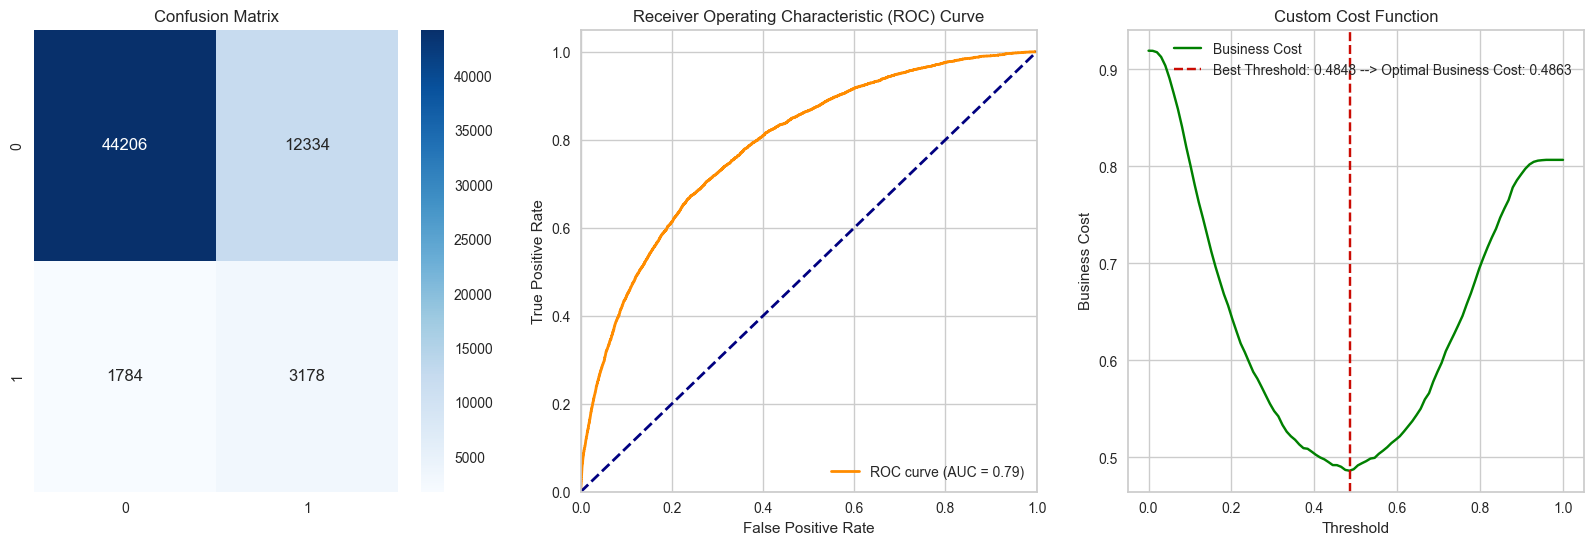

In [14]:
#!mlflow ui

^C


# FEATURE IMPORTANCE

In [8]:
import pandas as pd
train_df = pd.read_csv('train_df_cleaned.csv', index_col=0)
to_drop = ['TARGET','SK_ID_CURR']

## General interpretation

In [19]:
def perform_feature_selection(df, sorted_feature_importance, importance_type='gain', cumulative_importance_threshold=0.50, smoothing_window=5):
    """
    Perform feature selection based on LightGBM feature importance and SHAP values.

    Parameters:
    - df: DataFrame, input dataset.
    - sorted_feature_importance: DataFrame, sorted feature importance.
    - importance_type: str, type of feature importance ('gain' or 'split').
    - cumulative_importance_threshold: float, threshold for cumulative importance.
    - smoothing_window: int, window size for moving average smoothing.

    Returns:
    - selected_df: DataFrame, new DataFrame with selected features.
    """

    # Calculate cumulative importance
    cumulative_importance = np.cumsum(sorted_feature_importance['feature_importance_vals']) / np.sum(sorted_feature_importance['feature_importance_vals'])

    # Apply moving average smoothing to the cumulative importance
    smoothed_importance = np.convolve(cumulative_importance, np.ones(smoothing_window)/smoothing_window, mode='valid')

    # Determine the number of features to keep based on the cumulative importance threshold
    num_features_to_keep = np.argmax(smoothed_importance >= cumulative_importance_threshold) + 1

    # Select the top features
    selected_features = sorted_feature_importance['col_name'].head(num_features_to_keep).tolist()

    # Subset the dataset with selected features
    selected_df = df[selected_features]

    # Plot individual feature importance
    plt.figure(figsize=(16, 14))
    sns.barplot(x='feature_importance_vals', y='col_name', data=sorted_feature_importance.head(num_features_to_keep), palette='coolwarm')#,  hue='Metric')
    plt.title(f'Top Features based on {importance_type.capitalize()} Importance', fontsize=16)
    plt.xlabel(f'{importance_type.capitalize()} Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.show()

    # Plot cumulative importance
    plt.figure(figsize=(16, 12))
    plt.plot(smoothed_importance, marker='o', label='Cumulative Importance')
    plt.axhline(y=cumulative_importance_threshold, color='r', linestyle='--', label=f'Threshold: {cumulative_importance_threshold:.2f}')

    # Annotate the plot with the selected number of features
    plt.annotate(f'Selected {num_features_to_keep} features', xy=(num_features_to_keep, cumulative_importance_threshold),
                 xytext=(num_features_to_keep, 0.5), arrowprops=dict(facecolor='black', shrink=0.05, width=2), rotation='horizontal')

    plt.title('Smoothed Cumulative Feature Importance', fontsize=16)
    plt.xlabel('Number of Features', fontsize=14)
    plt.ylabel('Smoothed Cumulative Importance', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()

    return selected_df

def shap_plots(shap_values, features):
    gc.collect()

    # Plot and log SHAP summary plots
    #shap.summary_plot(shap_values, features.iloc[:num_instances, :], plot_type='bar', show=False, color_bar=False, max_display=15)
    # Set the figure size
    fig, ax = plt.subplots(figsize=(16, 12))
    shap.summary_plot(shap_values, features, plot_type='bar', show=False, color_bar=False, max_display=15)
    plt.title('SHAP Values Summary', fontsize=16)
    summary_class_bar = 'shap_summary.png'
    plt.savefig(summary_class_bar)
    mlflow.set_experiment("Optimized_model")
    with mlflow.start_run():
        mlflow.log_artifact(summary_class_bar)
        plt.show()
        plt.close()
        # Save decision plots for multiple instances
        for i in range(len(shap_values)):
            fig, ax = plt.subplots(figsize=(16, 12))
            shap.summary_plot(shap_values[i], features, show=False, color_bar=False, max_display=15)
            plt.title('SHAP Values Summary for class {}'.format(i), fontsize=16)
            summary_class = 'shap_summary_class_{}.png'.format(i)
            plt.savefig(summary_class)
            mlflow.log_artifact(summary_class)
            plt.show()
            plt.close()
    gc.collect()
    mlflow.end_run()

In [20]:
def calculate_feature_importance(shap_values, feature_names):
    """
    Calculate feature importance based on SHAP values.

    Parameters:
    - shap_values: np.ndarray, SHAP values.
    - feature_names: list, names of the features.

    Returns:
    - feature_importance: pd.DataFrame, sorted feature importance.
    """
    vals = np.abs(shap_values[0]).mean(0)
    feature_importance = pd.DataFrame(list(zip(feature_names, vals)), columns=['col_name', 'feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
    return feature_importance

In [87]:
gc.collect()
# SHAP values
explainer = shap.TreeExplainer(best_lgbm_classifier.booster_)
print('Got explainer')

explainer_path = 'lgbm_explainer.pkl'

with open(explainer_path, 'wb') as explainer_file:
     pickle.dump(explainer, explainer_file)

mlflow.set_experiment("Step4_LGBM_optimization")
with mlflow.start_run('781f3b5fd91d4b7eb50320dbce666211'):
    mlflow.log_artifact(explainer_path)

mlflow.end_run()

Got explainer


Traceback (most recent call last):
  File "c:\Users\Imtech\AppData\Local\Programs\Python\Python39\lib\site-packages\mlflow\store\tracking\file_store.py", line 271, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "c:\Users\Imtech\AppData\Local\Programs\Python\Python39\lib\site-packages\mlflow\store\tracking\file_store.py", line 405, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "c:\Users\Imtech\AppData\Local\Programs\Python\Python39\lib\site-packages\mlflow\store\tracking\file_store.py", line 1109, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "c:\Users\Imtech\AppData\Local\Programs\Python\Python39\lib\site-packages\mlflow\store\tracking\file_store.py", line 1102, in _read_helper
    result = read_yaml(root, file_name)
  File "c:\Users\Imtech\AppData\Local\Programs\Python\Python39\lib\site-packages\mlflow\utils\file_utils.py", line 183, in read_yaml


In [25]:
#shap_values = explainer.shap_values(features.iloc[:num_instances, :])
shap_values = explainer.shap_values(train_df.drop(to_drop, axis=1))
print('Got shap_values')
shap_values_path = "best_model_shap_values.pkl"

with open(shap_values_path, 'wb') as shap_values_file:
     pickle.dump(shap_values, shap_values_file)

mlflow.set_experiment("Step4_LGBM_optimization")
with mlflow.start_run('781f3b5fd91d4b7eb50320dbce666211'):
    mlflow.log_artifact(shap_values_path)

mlflow.end_run()

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Got shap_values


import gc
import pickle
import shap
import mlflow
import lightgbm
from mlflow import MlflowClient
mlflow.set_tracking_uri(r'file///C:\Users\Imtech\Desktop\DATA_SCIENTIST\PORJET_7\mlruns')

run_id = '781f3b5fd91d4b7eb50320dbce666211'
model_name = 'best_model_Step4_optimization'
model_uri = f"runs:/{run_id}/{model_name}"
best_lgbm_classifier = mlflow.sklearn.load_model(model_uri)
gc.collect()


#import mlflow
#import os
#import pickle
#
## Specify the experiment name and run ID
#run_id = '781f3b5fd91d4b7eb50320dbce666211'
#shap_values_path = 'best_model_shap_values.pkl'
#client = MlflowClient()
#
## Download the artifact
#local_artifacts_path = client.download_artifacts(run_id, '')
#
## Load the SHAP values
#shap_values_path_local = os.path.join(local_artifacts_path, shap_values_path)
#with open(shap_values_path_local, 'rb') as f:
#    shap_values = pickle.load(f)

#import pickle
#import os
#from shap import TreeExplainer
#
#client = MlflowClient()
#
## Specify the run ID and the artifact name
#run_id = '781f3b5fd91d4b7eb50320dbce666211'
#explainer_name = 'lgbm_explainer.pkl'
#
## Download the entire artifacts directory
#artifacts_path = client.download_artifacts(run_id, '')
#
## Full path to the artifact file
#artifact_file_path = os.path.join(artifacts_path, explainer_name)
#
## Load the artifact
#with open(artifact_file_path, 'rb') as f:
#    Myexplainer = pickle.load(f)
#
## Now you can use Myexplainer as needed
#print("Loaded explainer:", Myexplainer)



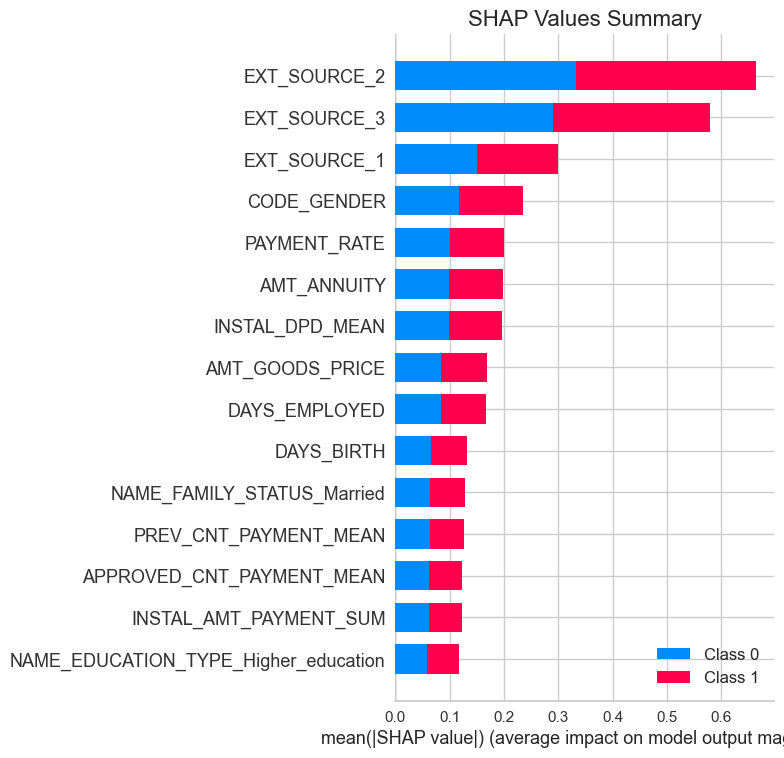

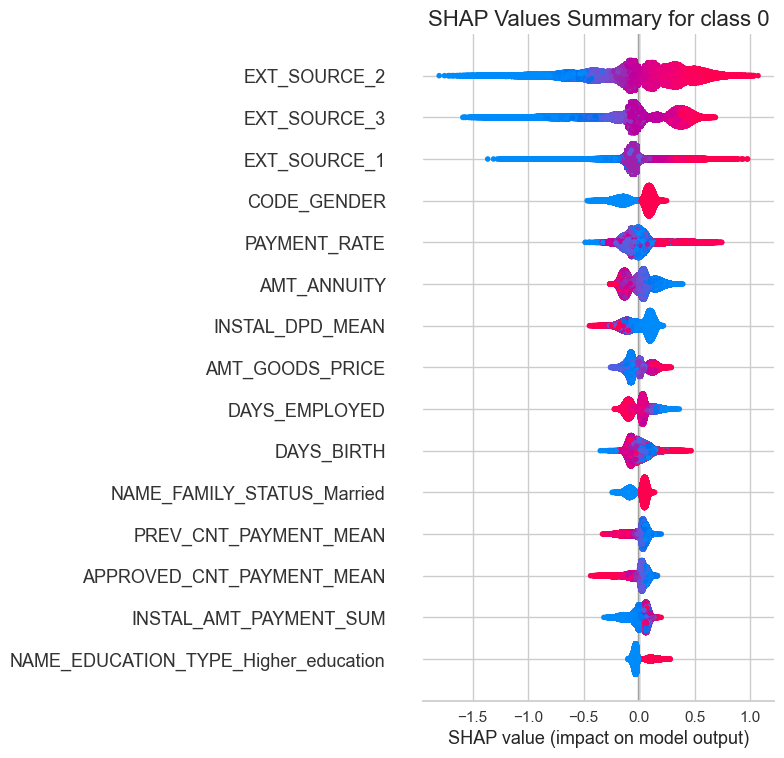

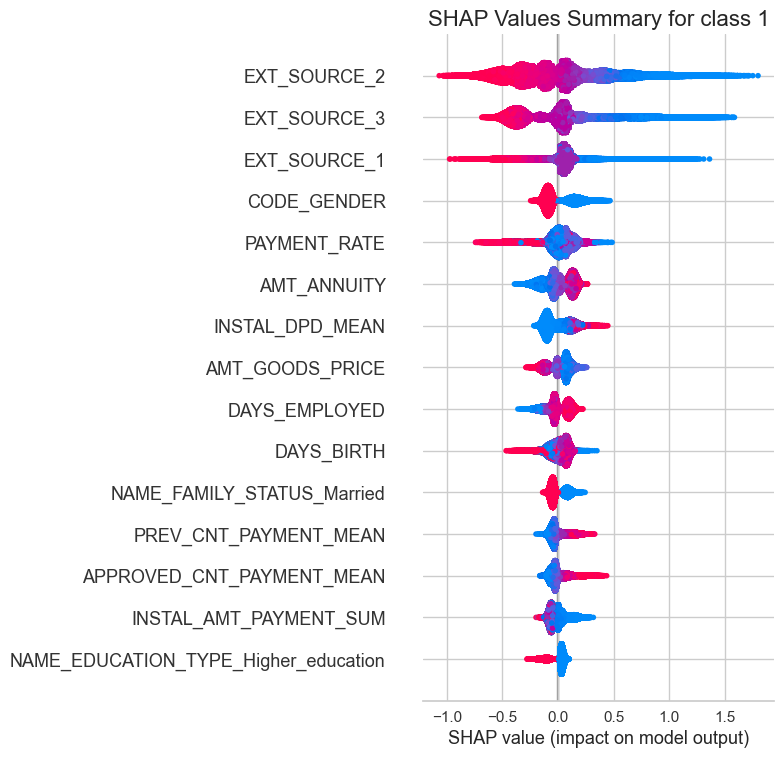

8330

In [21]:
shap_plots(shap_values, train_df.drop(to_drop, axis=1))
gc.collect()

## Local interpretation

In [22]:
train_df

,TARGET,SK_ID_CURR,ACTIVE_AMT_ANNUITY_MAX,ACTIVE_AMT_ANNUITY_MEAN,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_SUM_DEBT_MAX,ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,ACTIVE_AMT_CREDIT_SUM_DEBT_SUM,ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN,ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM,...,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
0,1.0,100002,-0.130141,-0.188615,-0.118068,-0.220865,-0.234318,-0.261044,0.193819,0.177838,...,0,0,0,1,-0.180023,-0.178254,-0.157692,-2.053894,-2.048198,-2.015872
1,0.0,100003,-0.025301,-0.032646,-0.123177,-0.421767,-0.391314,-0.425506,19.166195,9.512459,...,0,0,0,0,0.130041,0.128466,0.126624,0.635589,0.633402,0.641210
2,0.0,100004,-0.025301,-0.032646,-0.123177,-0.226045,-0.199214,-0.234826,-0.188356,-0.205962,...,0,0,0,0,0.045915,0.045247,0.049484,0.014939,0.015280,0.028158
3,0.0,100006,-0.025301,-0.032646,-0.123177,-0.226045,-0.199214,-0.234826,-0.188356,-0.205962,...,0,0,0,1,0.045915,0.045247,0.049484,0.014939,0.015280,0.028158
4,0.0,100007,-0.025301,-0.032646,-0.123177,-0.226045,-0.199214,-0.234826,-0.188356,-0.205962,...,0,1,0,0,0.045915,0.045247,0.049484,0.014939,0.015280,0.028158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0.0,456251,-0.025301,-0.032646,-0.123177,-0.226045,-0.199214,-0.234826,-0.188356,-0.205962,...,0,1,0,0,0.190131,0.187908,-0.025452,1.152797,1.150040,-0.789767
307507,0.0,456252,-0.025301,-0.032646,-0.123177,-0.226045,-0.199214,-0.234826,-0.188356,-0.205962,...,0,0,0,0,-0.168005,-0.166366,-0.146672,-1.950452,-1.945178,-1.914218
307508,0.0,456253,0.312815,0.706782,-0.123177,0.906349,0.755798,0.776157,-0.188356,-0.205962,...,0,1,0,0,0.045915,0.045247,0.049484,-0.088503,-0.087740,-0.073496
307509,1.0,456254,-0.025301,-0.032646,-0.123177,-0.226045,-0.199214,-0.234826,-0.188356,-0.205962,...,0,0,0,1,-0.062247,-0.061748,-0.047492,0.014939,0.015280,0.028158


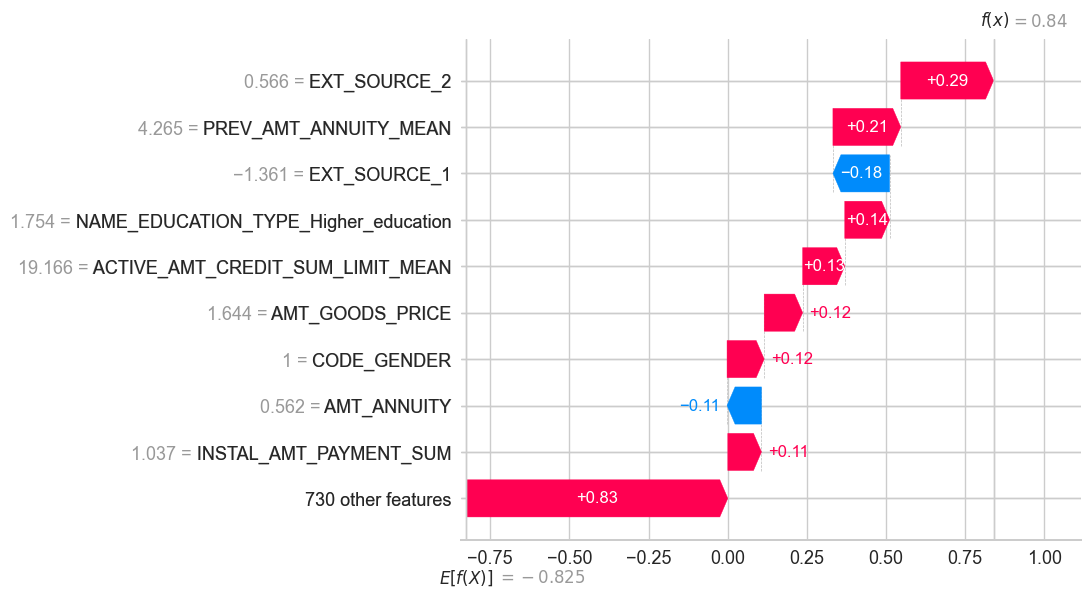

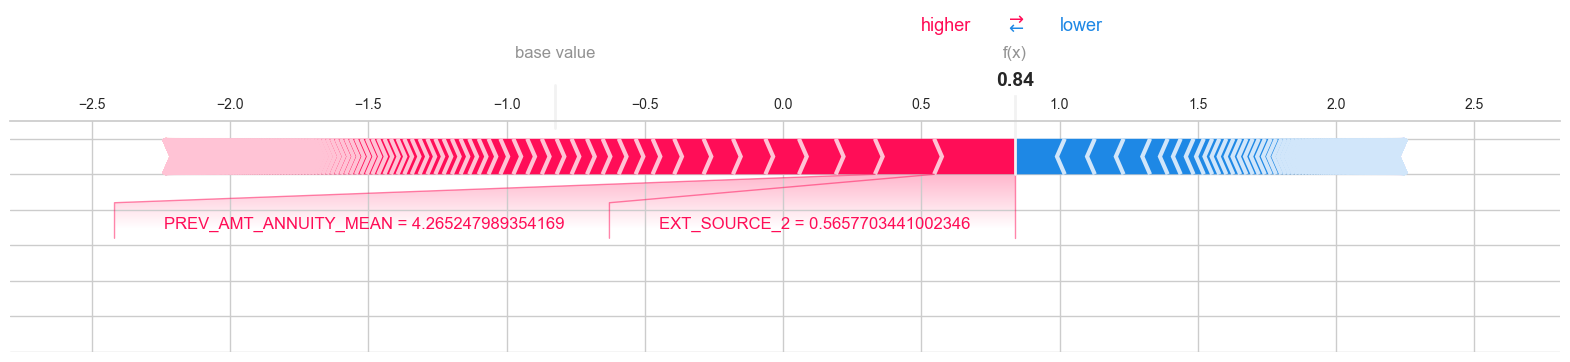

In [27]:
from shap import Explanation
import matplotlib

# SHAP values
explainer = shap.TreeExplainer(best_lgbm_classifier.booster_)

SK_ID_CURR = 100003

# Create an Explanation object
exp_0 = Explanation(values=shap_values[0], base_values=explainer.expected_value[0], data=train_df.drop(['TARGET', 'SK_ID_CURR'], axis=1).values,
    feature_names=train_df.drop(['TARGET', 'SK_ID_CURR'], axis=1).columns)
#exp_1 = Explanation(values=shap_values[1], base_values=explainer.expected_value[1], data=train_df.drop(['TARGET', 'SK_ID_CURR'], axis=1).values,
#    feature_names=train_df.drop(['TARGET', 'SK_ID_CURR'], axis=1).columns)
idx = train_df.loc[train_df['SK_ID_CURR'] == SK_ID_CURR].index
shap.plots.waterfall(exp_0[idx[0]], max_display=10) #, shap.plots.waterfall(exp_1[idx[0]], max_display=10)

shap.initjs()
shap.force_plot(exp_0[idx[0]],  matplotlib=matplotlib)
#shap.force_plot(exp_1[idx[0]],  matplotlib=matplotlib)

## Feature Selection

In [3]:
import pandas as pd
train_df = pd.read_csv(r'../train_df_cleaned.csv', index_col=0)
to_drop = ['TARGET','SK_ID_CURR']

FileNotFoundError: [Errno 2] No such file or directory: '../train_df_cleaned.csv'

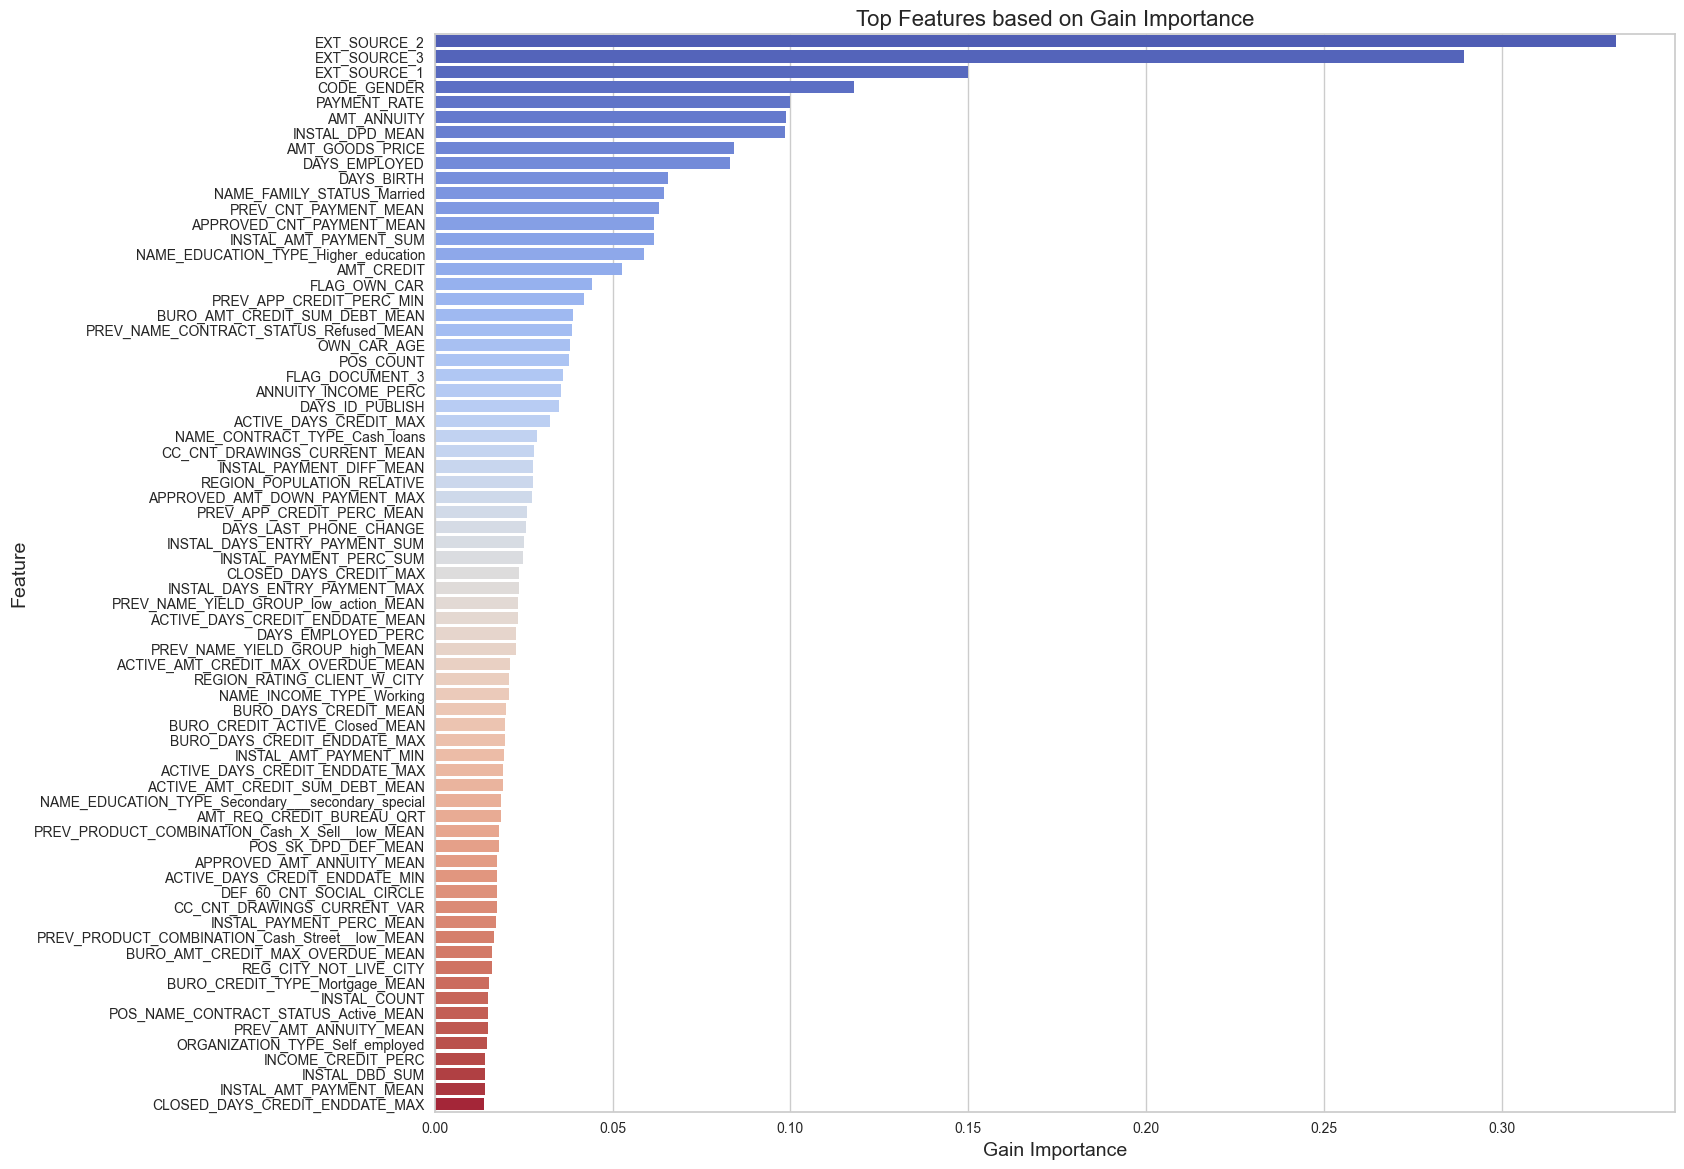

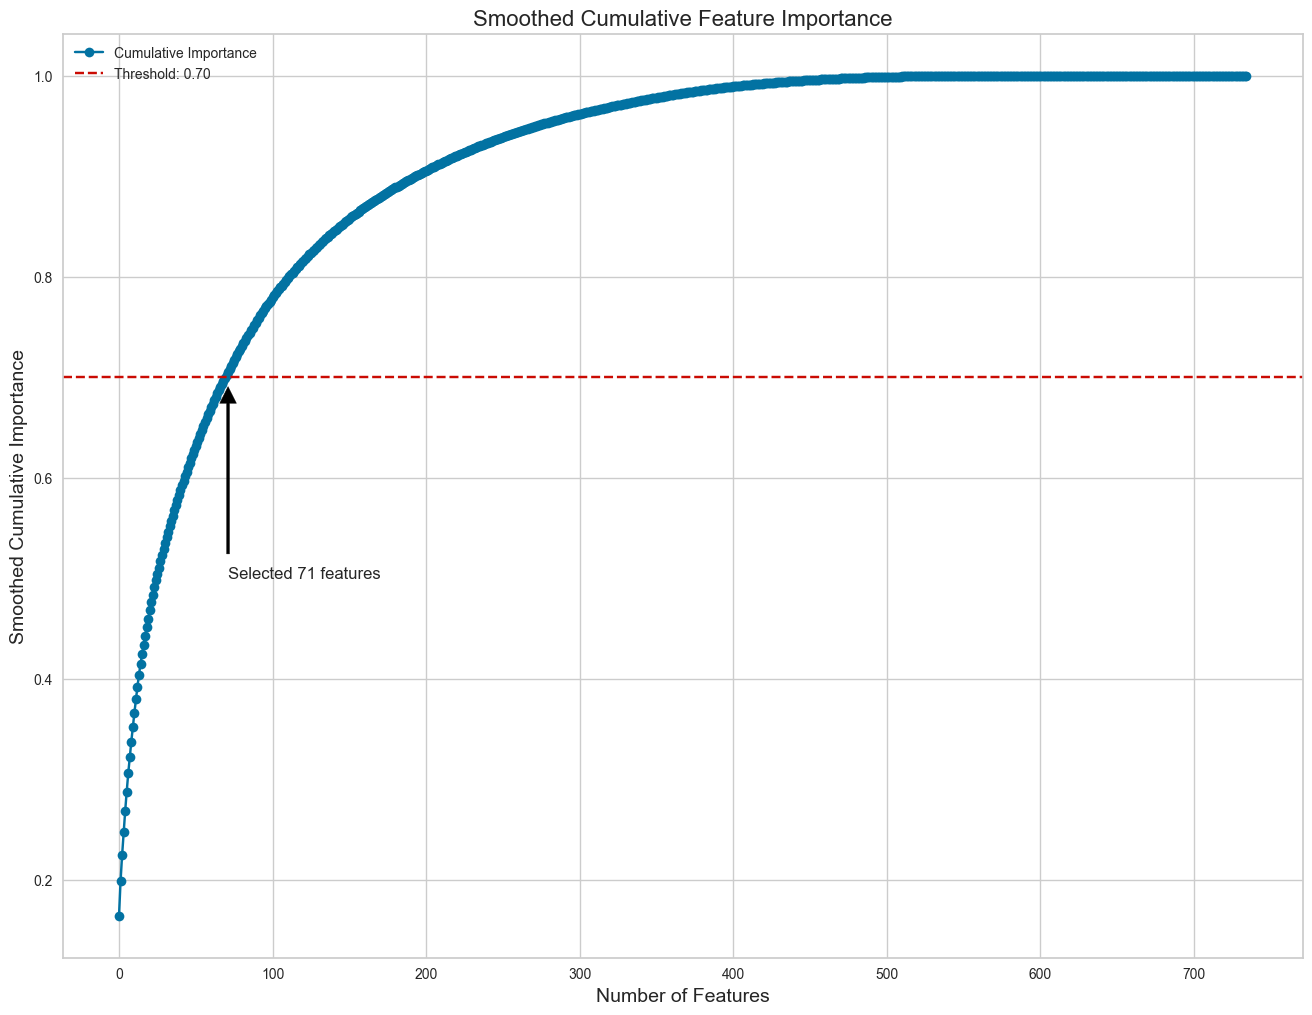

In [28]:
import numpy as np
import seaborn as sns
feature_names = train_df.drop(to_drop, axis=1).columns.tolist()
sorted_feature_importance = calculate_feature_importance(shap_values, feature_names)
selected_df_cleaned = perform_feature_selection(train_df, sorted_feature_importance, importance_type='gain', cumulative_importance_threshold=0.7, smoothing_window=5)
selected_df_cleaned.to_csv('train_df_cleaned_features_selection.csv')

In [29]:
sorted_feature_importance

,col_name,feature_importance_vals
288,EXT_SOURCE_2,0.332082
289,EXT_SOURCE_3,0.289317
287,EXT_SOURCE_1,0.149826
266,CODE_GENDER,0.117902
494,PAYMENT_RATE,0.099787
...,...,...
128,BURO_STATUS_4_MEAN_MEAN,0.000000
546,PREV_CODE_REJECT_REASON_SYSTEM_MEAN,0.000000
554,PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN,0.000000
303,FLAG_DOCUMENT_21,0.000000


## Model assessment on the selected features

In [30]:
selected_df_cleaned

,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_1,CODE_GENDER,PAYMENT_RATE,AMT_ANNUITY,INSTAL_DPD_MEAN,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_BIRTH,...,REG_CITY_NOT_LIVE_CITY,BURO_CREDIT_TYPE_Mortgage_MEAN,INSTAL_COUNT,POS_NAME_CONTRACT_STATUS_Active_MEAN,PREV_AMT_ANNUITY_MEAN,ORGANIZATION_TYPE_Self_employed,INCOME_CREDIT_PERC,INSTAL_DBD_SUM,INSTAL_AMT_PAYMENT_MEAN,CLOSED_DAYS_CREDIT_ENDDATE_MAX
0,-1.329384,-2.148489,-2.970285,0,0.227818,-0.184964,-0.113931,-0.483592,0.763316,1.509656,...,-0.291014,-0.163511,-0.506363,1.297513,-0.535413,-0.376997,0.173466,0.001292,-0.289207,-0.106421
1,0.565770,0.111310,-1.360846,1,-1.200809,0.561569,-0.113931,1.643871,0.504738,-0.166038,...,-0.291014,-0.163511,-0.357136,0.325758,4.265248,-0.376997,-0.409321,-0.521845,1.866789,-0.219310
2,0.215886,1.235660,0.013466,0,-0.235417,-1.403424,-0.113931,-1.073871,0.956663,-0.689348,...,-0.291014,-0.163511,-0.904300,-2.103628,-0.930665,-0.376997,0.177424,-0.912321,-0.470095,-0.210815
3,0.714493,0.111310,0.013466,1,1.701312,0.153481,-0.113931,-0.631162,-0.363916,-0.679941,...,-0.291014,-0.163511,-0.580976,-0.645996,0.925969,-0.376997,0.039932,-0.193946,1.793532,-0.171695
4,-1.014016,0.111310,0.013466,0,-0.553335,-0.377400,-0.003037,-0.040883,-0.363447,-0.892615,...,-0.291014,-0.163511,0.662578,0.472994,-0.228203,-0.376997,-0.352701,-0.211467,-0.262667,-0.300456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0.879012,0.111310,-2.529310,0,2.272597,0.009000,-0.113931,-0.827922,0.951501,1.540398,...,-0.291014,-0.163511,-0.804816,-1.725724,-0.803940,-0.376997,0.415886,-0.334117,-0.454014,-0.171695
307507,-2.104523,0.111310,0.013466,1,-0.471395,-1.046958,-0.055844,-0.827922,0.281825,-1.086017,...,-0.291014,-0.163511,-0.829687,-0.645996,-0.451919,-0.376997,-0.291723,-0.919830,-0.349571,-0.171695
307508,0.109389,-1.692732,1.690893,1,-0.483697,0.173335,-0.039248,0.155876,-2.654984,0.246691,...,-0.291014,-0.163511,-0.630718,-0.303024,-0.990224,-0.376997,-0.374994,-0.439245,-0.590883,-0.167672
307509,-0.004326,0.842634,0.013466,1,-0.037513,-0.490113,-0.113931,-0.569675,-1.183763,0.936103,...,3.436259,-0.163511,-0.506363,1.297513,-0.390349,-0.376997,0.100931,-0.066291,-0.342682,-0.317445


In [33]:
selected_df_cleaned['SK_ID_CURR'] = train_df['SK_ID_CURR']
selected_df_cleaned['TARGET'] = train_df['TARGET']
selected_df_cleaned

,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_1,CODE_GENDER,PAYMENT_RATE,AMT_ANNUITY,INSTAL_DPD_MEAN,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_BIRTH,...,INSTAL_COUNT,POS_NAME_CONTRACT_STATUS_Active_MEAN,PREV_AMT_ANNUITY_MEAN,ORGANIZATION_TYPE_Self_employed,INCOME_CREDIT_PERC,INSTAL_DBD_SUM,INSTAL_AMT_PAYMENT_MEAN,CLOSED_DAYS_CREDIT_ENDDATE_MAX,SK_ID_CURR,TARGET
0,-1.329384,-2.148489,-2.970285,0,0.227818,-0.184964,-0.113931,-0.483592,0.763316,1.509656,...,-0.506363,1.297513,-0.535413,-0.376997,0.173466,0.001292,-0.289207,-0.106421,100002,1.0
1,0.565770,0.111310,-1.360846,1,-1.200809,0.561569,-0.113931,1.643871,0.504738,-0.166038,...,-0.357136,0.325758,4.265248,-0.376997,-0.409321,-0.521845,1.866789,-0.219310,100003,0.0
2,0.215886,1.235660,0.013466,0,-0.235417,-1.403424,-0.113931,-1.073871,0.956663,-0.689348,...,-0.904300,-2.103628,-0.930665,-0.376997,0.177424,-0.912321,-0.470095,-0.210815,100004,0.0
3,0.714493,0.111310,0.013466,1,1.701312,0.153481,-0.113931,-0.631162,-0.363916,-0.679941,...,-0.580976,-0.645996,0.925969,-0.376997,0.039932,-0.193946,1.793532,-0.171695,100006,0.0
4,-1.014016,0.111310,0.013466,0,-0.553335,-0.377400,-0.003037,-0.040883,-0.363447,-0.892615,...,0.662578,0.472994,-0.228203,-0.376997,-0.352701,-0.211467,-0.262667,-0.300456,100007,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0.879012,0.111310,-2.529310,0,2.272597,0.009000,-0.113931,-0.827922,0.951501,1.540398,...,-0.804816,-1.725724,-0.803940,-0.376997,0.415886,-0.334117,-0.454014,-0.171695,456251,0.0
307507,-2.104523,0.111310,0.013466,1,-0.471395,-1.046958,-0.055844,-0.827922,0.281825,-1.086017,...,-0.829687,-0.645996,-0.451919,-0.376997,-0.291723,-0.919830,-0.349571,-0.171695,456252,0.0
307508,0.109389,-1.692732,1.690893,1,-0.483697,0.173335,-0.039248,0.155876,-2.654984,0.246691,...,-0.630718,-0.303024,-0.990224,-0.376997,-0.374994,-0.439245,-0.590883,-0.167672,456253,0.0
307509,-0.004326,0.842634,0.013466,1,-0.037513,-0.490113,-0.113931,-0.569675,-1.183763,0.936103,...,-0.506363,1.297513,-0.390349,-0.376997,0.100931,-0.066291,-0.342682,-0.317445,456254,1.0


[LightGBM] [Info] Number of positive: 20034, number of negative: 225971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13620
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081437 -> initscore=-2.422976
[LightGBM] [Info] Start training from score -2.422976
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
<class 'pandas.core.ser

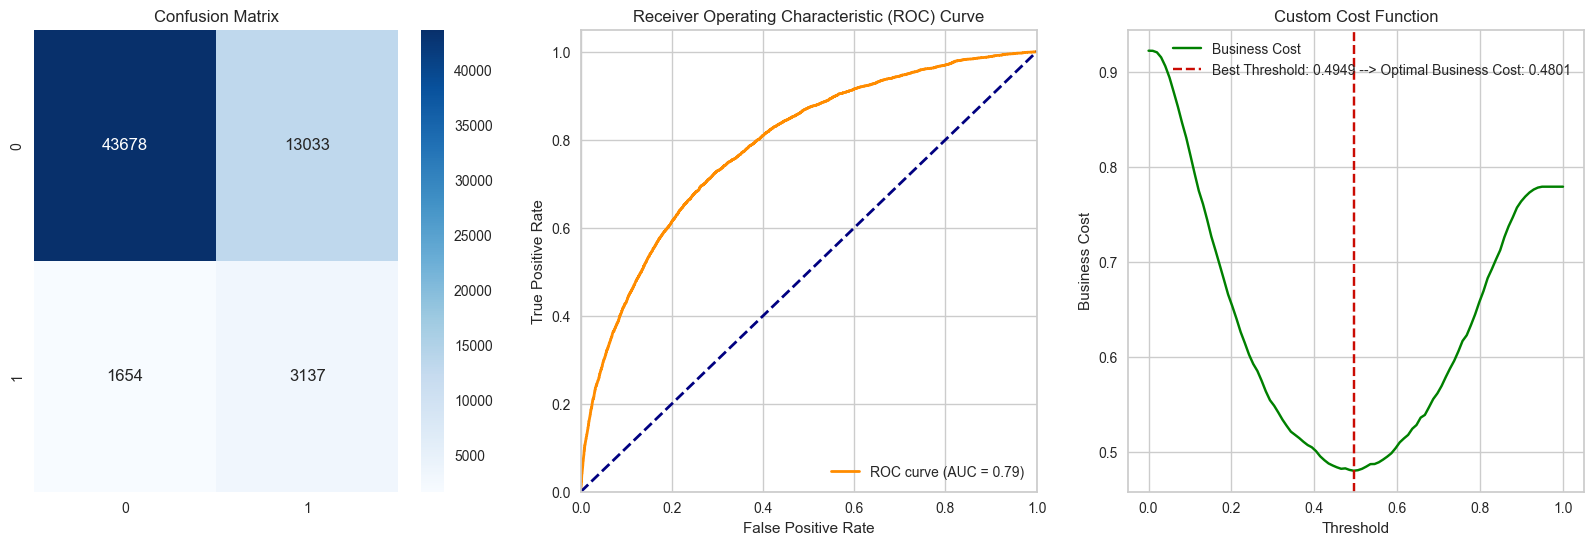

In [48]:
from sklearn.model_selection import GridSearchCV, train_test_split

to_drop = ['TARGET','SK_ID_CURR']
X_train, X_val, y_train, y_val = train_test_split(
   selected_df_cleaned.drop(to_drop, axis=1),
    selected_df_cleaned['TARGET'],
    test_size=0.2
)

# Save the best model using pickle
best_lgbm_classifier.fit(X_train, y_train)
plot_file_path = 'Business_Cost_minimization_Features_selection.png'

# Evaluate and plot the best model
business_metric, auc_score, accuracy, precision, recall, f1 = evaluate_and_plot_best_model(best_lgbm_classifier, X_val, y_val, plot_file_path)

mlflow.set_experiment("Step5_Best_model_on_features_selection")
with mlflow.start_run():
    mlflow.sklearn.log_model(best_lgbm_classifier, "Best_model_on_features_selection")
    # Log hyperparameters and metrics to mlflow
    #mlflow.log_params(retrieve_best_params_BC)
    mlflow.log_metric('Accuracy', accuracy)
    mlflow.log_metric('Precision', precision)
    mlflow.log_metric('Recall', recall)
    mlflow.log_metric('F1 Score', f1)
    mlflow.log_metric('Lowest business Cost', business_metric)
    mlflow.log_metric('AUC Score', auc_score)

    # Log the plot as an artifact if it exists
    if os.path.exists(plot_file_path):
        mlflow.log_artifact(plot_file_path)
    else:
        print(f"Warning: The file '{plot_file_path}' does not exist. The plot artifact will not be logged.")

mlflow.end_run()

In [12]:
!mlflow ui

'mlflow' is not recognized as an internal or external command,
operable program or batch file.


In [49]:
best_lgbm_classifier.feature_name_

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'EXT_SOURCE_1',
 'CODE_GENDER',
 'PAYMENT_RATE',
 'AMT_ANNUITY',
 'INSTAL_DPD_MEAN',
 'AMT_GOODS_PRICE',
 'DAYS_EMPLOYED',
 'DAYS_BIRTH',
 'NAME_FAMILY_STATUS_Married',
 'PREV_CNT_PAYMENT_MEAN',
 'APPROVED_CNT_PAYMENT_MEAN',
 'INSTAL_AMT_PAYMENT_SUM',
 'NAME_EDUCATION_TYPE_Higher_education',
 'AMT_CREDIT',
 'FLAG_OWN_CAR',
 'PREV_APP_CREDIT_PERC_MIN',
 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
 'PREV_NAME_CONTRACT_STATUS_Refused_MEAN',
 'OWN_CAR_AGE',
 'POS_COUNT',
 'FLAG_DOCUMENT_3',
 'ANNUITY_INCOME_PERC',
 'DAYS_ID_PUBLISH',
 'ACTIVE_DAYS_CREDIT_MAX',
 'NAME_CONTRACT_TYPE_Cash_loans',
 'CC_CNT_DRAWINGS_CURRENT_MEAN',
 'INSTAL_PAYMENT_DIFF_MEAN',
 'REGION_POPULATION_RELATIVE',
 'APPROVED_AMT_DOWN_PAYMENT_MAX',
 'PREV_APP_CREDIT_PERC_MEAN',
 'DAYS_LAST_PHONE_CHANGE',
 'INSTAL_DAYS_ENTRY_PAYMENT_SUM',
 'INSTAL_PAYMENT_PERC_SUM',
 'CLOSED_DAYS_CREDIT_MAX',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'PREV_NAME_YIELD_GROUP_low_action_MEAN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_M

## Make shap values for the model with the features selection

In [44]:
gc.collect()
# SHAP values
explainer_features_selection = shap.TreeExplainer(best_lgbm_classifier.booster_)
print('Got explainer')

shap_values_features_selection = explainer_features_selection.shap_values(selected_df_cleaned.drop(to_drop, axis=1))
print('Got shap values')

explainer_path_features_selection = 'lgbm_explainer_features_selection.pkl'

with open(explainer_path_features_selection, 'wb') as explainer_file:
     pickle.dump(explainer_features_selection, explainer_file)

shap_values_path_features_selection = "best_model_shap_values_features_selection.pkl"

with open(shap_values_path_features_selection, 'wb') as shap_values_file:
     pickle.dump(shap_values, shap_values_file)

mlflow.set_experiment("Step5_Best_model_on_features_selection")
with mlflow.start_run('5104f2813642440881b66176bda6224c'):
    mlflow.log_artifact(explainer_path_features_selection)
    mlflow.log_artifact(shap_values_path_features_selection)

mlflow.end_run()

Got explainer
Got shap values


smaple to use in the cloud testing

In [45]:
df_test_sample_100 = pd.read_csv('test_df_cleaned.csv')[selected_df_cleaned.drop('TARGET', axis=1).columns].head(100).to_csv('test_df_cleaned_head_100.csv')

The performance of the model on the selected features is quite similar to the trained model on all features. For this reason we can validate this model and make it working in the API/Dashboard side 

# Data Drift assessment

In [ ]:
#pip install --upgrade evidently
#pip install --upgrade pydantic

In [16]:
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

df_test_sample = pd.read_csv('test_df_cleaned.csv')[selected_df_cleaned.drop(to_drop, axis=1).columns].sample(30000)

data_drift_report = Report(metrics=[DataDriftPreset(),])
print('data_drift_report init')
data_drift_report.run(current_data=df_test_sample, reference_data=selected_df_cleaned.drop(to_drop, axis=1).sample(30000), column_mapping=None)
print('data_drift_report run')
data_drift_report.save_html("data_drift_report.html")
print('data_drift_report html')

NameError: name 'selected_df_cleaned' is not defined